## CANYON-MED 
Implementation following the instruction of the article *'A Regional Neural Network Approach to  estimate Water-COlumn Nutrient COncentrations and Carbonate System Variables in the Mediterranean Sea: CANYON-MED'*

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from blitz.modules import BayesianLinear
from IPython import display
from torchvision import datasets, transforms
from res.plot_lib import plot_data, plot_model, set_default
from matplotlib import pyplot as plt

from datetime import datetime as dt
import time

In [3]:
torch.tensor([2,4])

tensor([2, 4])

In [2]:
set_default()

In [3]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [4]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [5]:
A=4/3
a=1.7159
def mysigmoid(x):
    return A*torch.sigmoid(x*a/2) 

class MySigmoid(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return mysigmoid(x)
        
activation_function = MySigmoid() 

In [6]:
data=pd.read_csv("../dataset/data_AT.csv")
mont_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

dataset=data[data.categ=='training']          
validation=data[data.categ=='validation']

out_d=dataset['alkali'].to_numpy()
in_d=dataset[['latitude', 'longitude', 'pres', 'temp', 'doxy', 'psal']].to_numpy()

out_v=validation['alkali'].to_numpy()
in_v=validation[['latitude', 'longitude', 'pres', 'temp', 'doxy', 'psal']].to_numpy()

In [7]:
def fixd(dataset):
    for i in range(len(dataset[:,0])):
        dataset[i,0] = dt(int(dataset[i,0][7:11]), mont_dict[dataset[i,0][3:6]] , int(dataset[i,0][0:2]))
        dataset[i,0] = toYearFraction(dataset[i,0])

#fixd(in_d)
#fixd(in_v)
in_d=in_d.astype('float64')
in_v=in_v.astype('float64')

In [8]:
data = torch.from_numpy(in_d)
target = torch.from_numpy(out_d)
data=data.float()
target=target.float()

In [9]:
def prep_dataset(data):
    for i in range(len(data[:,0])):
        if data[i,4]>180:
            data[i,4]=data[i,4]-360                                                  #longitude
    data[:,3]=data[:,3]/90                                                           #latitude [-90,90]/90
    data[:,5]=(data[:,5]/20000) + (1 / ((1+np.exp(-(data[:,5])/300))**3))            #pressure
    return data

data=prep_dataset(data)

In [10]:
def norm_fun_d(data):
    mean=[ data[:,i].mean() for i in range(data.size()[1]) ]
    std =[ data[:,i].std() for i in range(data.size()[1]) ]
    for i in range(data.size()[1]):
        data[:,i]=2/3*(data[:,i]-mean[i])/std[i] 
    return data, mean, std

data, mean_data, std_data=norm_fun_d(data)

In [11]:
target

tensor([2536.0000, 2580.0000, 2592.0000,  ..., 2499.7100, 2462.8501,
        2460.1899])

In [12]:
def norm_fun_t(target):
    tar_mean,tar_std=target.mean(), target.std()
    target=(target-tar_mean)/tar_std
    return target

target=norm_fun_t(target)

In [13]:
target

tensor([-0.8593,  0.0314,  0.2744,  ..., -1.5939, -2.3401, -2.3939])

In [14]:
i=6 #input number
best_topo_all=[[i,31,23,1],[i,20,8,1],[i,18,13,1],[i,35,21,1],[i,35,9,1],[i,36,21,1],[i,39,26,1],[i,44,27,1],[i,47,21,1],[i,47,29,1]]

def top_select(best_topo_all, n):
    best_topo=best_topo_all[0:n]
    return best_topo  

best_topo=top_select(best_topo_all,1)

In [15]:
class MLP_Bayesian(nn.Module):
    def __init__(self, top):
        input_size, n_hidden1, n_hidden2, output_size = best_topo[top]
        super( MLP_Bayesian , self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            BayesianLinear(input_size, n_hidden1), #nn.Linear(input_size, n_hidden1), #
            nn.Hardtanh(), #nn.Sigmoid(),  #funzione bene con nn.ReLU(), ELU(),
            BayesianLinear(n_hidden1, n_hidden2), #nn.Linear(n_hidden1, n_hidden2), #
            nn.Hardtanh(), #nn.Sigmoid(), 
            BayesianLinear(n_hidden2, output_size), #nn.Linear(n_hidden2, output_size), #
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

In [16]:
accuracy_list = []
losses= [] 
def train(model, ep):
    
    for t in range(ep):
        
        output = model(data)
        criterion=torch.nn.L1Loss()                                        #criterion=torch.nn.L1Loss()
        loss = criterion(output, target)
        losses.append(loss)
        
        print(f"[MODEL]: {top+1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [17]:
models=list()
models_loss=[]
epoch=500
for top in range(len(best_topo)):
    model_mlp=MLP_Bayesian(top)
    models.append(model_mlp)
    optimizer = optim.Adam(model_mlp.parameters(), lr=0.05)# , momentum=1)
    train(model_mlp, epoch)

model=models[0]
result=model(data)

[MODEL]: 1, [EPOCH]: 499, [LOSS]: 0.628810


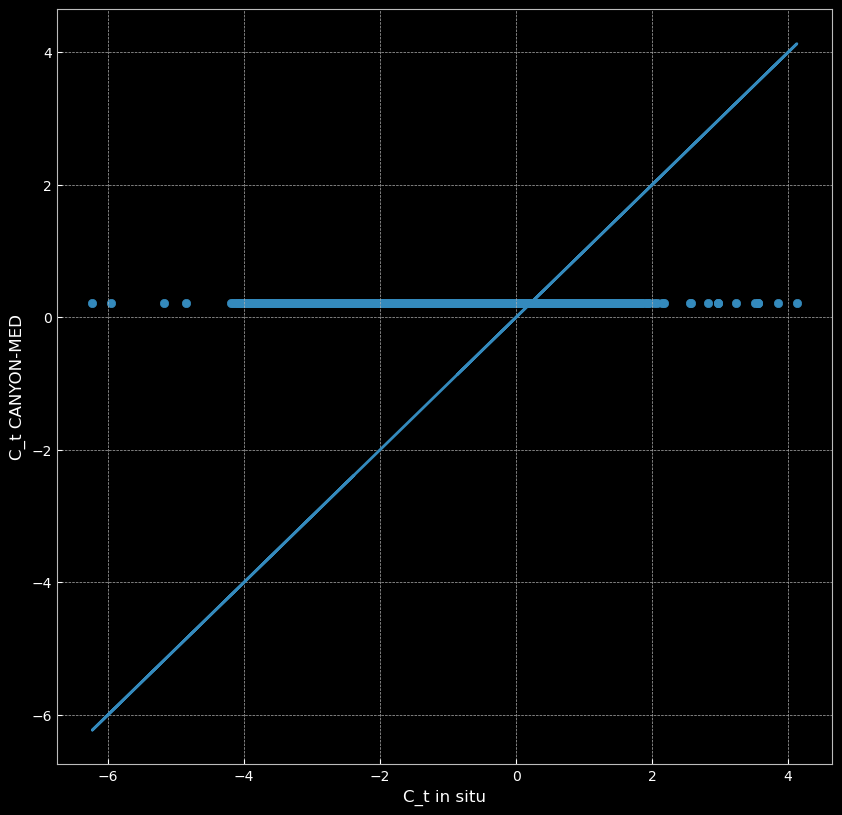

In [18]:
def plot_sol(sol,prev): 
    plt.scatter(sol.detach().numpy() ,prev.detach().numpy())
    plt.plot(sol, sol)
    plt.xlabel('C_t in situ')
    plt.ylabel('C_t CANYON-MED')
    
plot_sol(target, result)

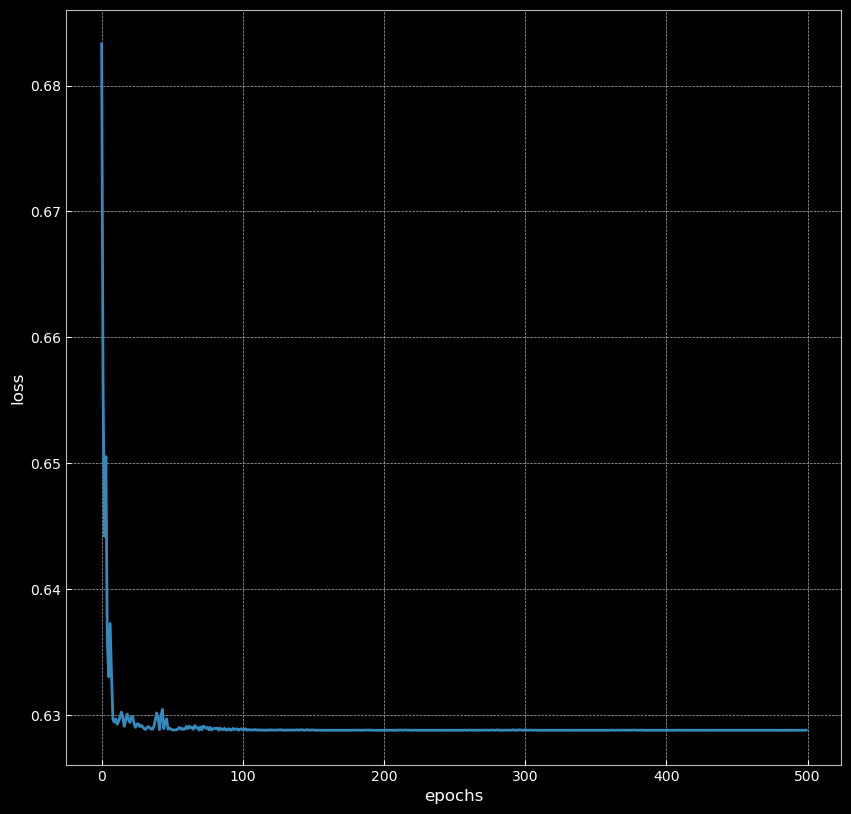

In [19]:
def error_plot(ep, losses):
    ep_vect=[i for i in range(ep)]
    plt.plot(ep_vect, losses, label= 'loss during epochs')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    
error_plot(epoch, losses)

### LINEAR COMBINATION OF THE BEST 10 OUTPUTS

In [20]:
def ct_result(my_input):
    outputs=[]
    for top in range(len(best_topo)):
        my_model=models[top]
        my_output=my_model(my_input)
        outputs.append(my_output)
    out=sum(outputs)/len(outputs)
    return out

#out=ct_result(X_new)